In [107]:
import os
from collections import Counter

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from tqdm import tqdm

from preprocess import (
    remove_punctuation,
    split_sentences,
    process_suffixes,
    get_suffixes,
)

In [19]:
# CONSTANTS
CORPUS_PATH = './corpus'
SUFFIXES = get_suffixes()
WORDS_COUNT_FILE = 'words_count.txt'
PAIR_COOCCURENCES_FILE = 'pair_cooccurences.txt'
MIN_COUNT_THRESHOLD = 2  # All the tokens with counts less than or equal to this will be ignored from consideration
CO_OCCURENCE_WINDOW = 2  # Consider window of two words to consider to have "co-occured"

In [20]:
# GET CORPUS
content_files = os.listdir(CORPUS_PATH)

all_content = []

for filename in content_files:
    path = os.path.join(CORPUS_PATH, filename)
    with open(path, 'r') as f:
        all_content.append(f.read())


In [21]:
def clean_and_extract_sentences(text):
    clean = remove_punctuation(text)
    sentences = split_sentences(clean)
    sentences_word_list = []
    for sentence in sentences:
        splitted = [x for x in sentence.split() if x]
        suffix_processed = process_suffixes(SUFFIXES, splitted)
        sentences_word_list.append(
            [x for x in suffix_processed if x]
        )
    return sentences_word_list

In [22]:
# Get unique words and their corresponding count within corpus
words_count = Counter()
for content in all_content:
    cleaned_sentences = clean_and_extract_sentences(content)
    for sentence in cleaned_sentences:
        words_count.update(sentence)

# Remove low count items
words_count = {k: v for k, v in words_count.items() if v > MIN_COUNT_THRESHOLD}
print(len(words_count))

43355


In [23]:
# Save words list, sorted
import time
s = time.time()
sorted_words_list = sorted(words_count.items(), key=lambda x: x[1], reverse=True)
e = time.time()
print('Time taken to sort : ', e - s)

def write_to_file():
    with open(WORDS_COUNT_FILE, 'w') as f:
        for k, v in sorted_words_list:
            f.write(f'{k} {v}\n')
write_to_file()
print('WRITTEN')

Time taken to sort :  0.01614999771118164
WRITTEN


In [24]:
# LOAD WORD IDS
words_ids = dict()
with open(WORDS_COUNT_FILE, 'r') as f:
    for i, line in enumerate(f.readlines()):
        word, _ = line.split()
        words_ids[word] = i
print('WORD_IDS LOADED')

WORD_IDS LOADED


In [25]:
def get_sentence_cooccurences(sentence_word_ids):
    occurences = Counter()
    for i in range(CO_OCCURENCE_WINDOW):
        shifted = sentence_word_ids[i+1:]
        pairs = zip(sentence_word_ids, shifted)
        sorted_pairs = [tuple(sorted(pair)) for pair in pairs]  # Only work on sorted tuple as (1,2) and (2,1) have same values in the matrix
        occurences.update(Counter(sorted_pairs))
    return occurences

print(get_sentence_cooccurences([1,2,3,4,5,3,1]))

Counter({(3, 4): 2, (3, 5): 2, (1, 3): 2, (1, 2): 1, (2, 3): 1, (4, 5): 1, (2, 4): 1, (1, 5): 1})


In [31]:
pair_cooccurences = Counter()
# Use the sentences list to create coocrurence matrix
for content in all_content:
    cleaned_sentences = clean_and_extract_sentences(content)
    for sentence in cleaned_sentences:
        word_ids = [words_ids[w] for w in sentence if w in words_ids]
        occurences = get_sentence_cooccurences(word_ids)
        pair_cooccurences.update(occurences)
print('DONE creating pair cooccurences')

DONE creating pair cooccurences


In [32]:
# Write pair_cooccurences to a file
print(len(pair_cooccurences))
with open(PAIR_COOCCURENCES_FILE, 'w') as f:
    for (w1_id, w2_id), cooccurences in pair_cooccurences.items():
        f.write(f'{w1_id} {w2_id} {cooccurences}\n')
print(f'Written cooccurences to file {PAIR_COOCCURENCES_FILE}')

2544211
Written cooccurences to file pair_cooccurences.txt


In [75]:
## NOW all the data is processed, we just need to load cooccurences and words_ids files to work with creating vector embeddings

print('LOADING WORD_IDS')
word_ids = {}
word_ids_reverse = {}
with open(WORDS_COUNT_FILE, 'r') as f:
    for i, line in enumerate(f.readlines()):
        if not line.strip():
            continue
        word, _ = line.split()
        word_ids[word] = i
        word_ids_reverse[i] = word
print('LOADED WORD_IDS.')


cooccurrences_symmetric = dict()
print('LOADING COOCCURRENCES...')
with open(PAIR_COOCCURENCES_FILE, 'r') as f:
    for line in f.readlines():
        if not line.strip():
            continue
        w1, w2, occ = line.split()
        pair = tuple(sorted([int(w1), int(w2)]))
        cooccurrences_symmetric[pair] = int(occ)
print('LOADED COOCCURRENCES.')

LOADING WORD_IDS
LOADED WORD_IDS.
LOADING COOCCURRENCES...
LOADED COOCCURRENCES.


In [77]:

def get_standard_deviations(cooccurrences_symmetric, word_ids):
    """
    Get variance of given dimension(here each word contributes as a dimension)
    This will later be used to filter out non varying dimensions
    @parameters:
        - cooccurrences_symmetric: cooccurence matrix
        - word_ids: words(dimensions)
    @returns: a float denoting the variance
    """
    vocab_size = len(word_ids)
    word_cols = {v: [] for v in word_ids.values()}
    word_mean = dict()
    for (w1, w2), occ in tqdm(cooccurrences_symmetric.items()):
        if w1 == w2:
            word_cols[w1].append(occ)
        else:
            word_cols[w1].append(occ)
            word_cols[w2].append(occ)
            
    for k,v in word_cols.items():
        word_mean[k] = sum(v) / vocab_size
    # Now get stds
    stds = dict()
    for k, cols in word_cols.items():
        count = len(cols)
        diff = vocab_size - count  # to account for all the zero values not included in the cols list
        sq_sum = sum([(v - word_mean[k])**2 for v in cols]) + diff * (word_mean[k]**2)
        var = (sq_sum / vocab_size)**0.5
        stds[k] = var
    
    return stds

stds = get_standard_deviations(cooccurrences_symmetric, word_ids)

# sort by min
sorted_stds = sorted(stds.items(), key=lambda x: x[1], reverse=True)


100%|██████████| 2544211/2544211 [00:01<00:00, 2055980.84it/s]


In [90]:
print(len(word_ids), len(word_ids) * 500)
[(word_ids_reverse[w], std) for w, std in sorted_stds[:500]]

43355 21677500


[('N', 314.57061585146124),
 ('जना', 141.90838150508387),
 ('छ', 120.31633821104067),
 ('भए', 116.89596953583634),
 ('र', 101.6471204887892),
 ('हजार', 94.8245688004677),
 ('गरे', 83.18251651923703),
 ('लाई', 81.90002150303681),
 ('कोरोना', 76.7537196709119),
 ('काठमाडौं', 68.97008435760081),
 ('संक्रमण', 67.68804494966761),
 ('लाख', 57.67700680926944),
 ('उन', 57.24165414729157),
 ('पनि', 56.076446846906755),
 ('भने', 55.570557723674945),
 ('सय', 53.89468574189847),
 ('गते', 52.68251183734964),
 ('मृत्यु', 50.38775891757052),
 ('पुष्टि', 49.458200712918284),
 ('छन्', 49.32864497162342),
 ('बाट', 47.70868955195903),
 ('दिए', 45.035118089709634),
 ('पछि', 44.274414161033675),
 ('वर्ष', 43.73484250200516),
 ('करोड', 41.996482855712074),
 ('देखि', 41.35386184500176),
 ('संक्रमित', 40.959078494575785),
 ('जानकारी', 40.58613469179143),
 ('सम्म', 39.86162369334996),
 ('रुपैयाँ', 37.12106556501025),
 ('सरकार', 35.150934103988114),
 ('प्रतिशत', 34.619055737065594),
 ('जनाए', 34.11443203223226)

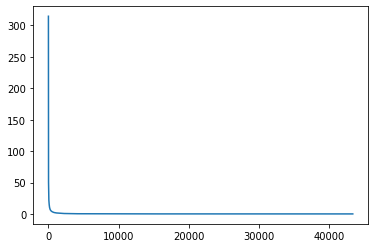

In [96]:
# plot standard deviations
choosen = sorted_stds[:]
std_vals = np.array([v for _, v in choosen])
plt.plot(np.arange(len(choosen)), std_vals)

In [98]:
# Consider only certain number of dimensions with highest standard deviations
N_DIMS_SELECTED = 5000
choosen_dimensions = {k for k, _ in sorted_stds[:N_DIMS_SELECTED]}

# NOW create sparse matrix of all words and their vector representations
all_words_embeds = dict()
for v in tqdm(word_ids.values()):
    vector = []
    for dim in choosen_dimensions:
        pair = tuple(sorted([v, dim]))
        vector.append(cooccurrences_symmetric.get(pair, 0))
    all_words_embeds[v] = vector
print('DONE!!')

100%|██████████| 43355/43355 [02:42<00:00, 266.74it/s]

DONE!!


In [101]:
import json
# write dimensions and word vectors to json
RAW_VECTORS_PATH = 'raw_vectors.json'
with open(RAW_VECTORS_PATH, 'w') as f:
    d = {'dimensions': list(choosen_dimensions)}
    d['word_embeddings'] = all_words_embeds
    f.write(json.dumps(d))
print('done writing')

done writing


In [103]:
# READ RAW vectors
with open(RAW_VECTORS_PATH, 'r') as f:
    vectors_data = json.load(f)
print('LOADED VECTORS')
sparse_matrix = sparse.csr_matrix([v for k, v in vectors_data['word_embeddings'].items()])
print('CREATED SPARSE MATRIX')

LOADED VECTORS
CREATED SPARSE MATRIX


(43355, 5000)


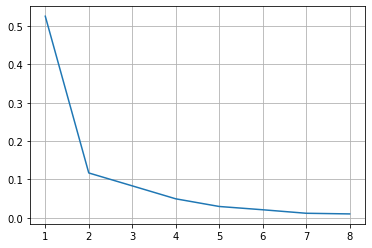

In [119]:
# Perform dimension reduction
print(sparse_matrix.shape)
components = 8
tsvd = TruncatedSVD(n_components=components)
tsvd.fit(sparse_matrix)
plt.plot(np.arange(1, components+1), tsvd.explained_variance_ratio_)
plt.grid(True)